In [1]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [2]:
!pip3 install tensorflow==2.15.0
!pip3 install -U tensorflow-quantum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import collections
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [4]:
import os
import time
import shutil
import pathlib
import itertools

In [5]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# 1. Dataset

You can find the original dataset here: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

I already resized the images to (200,200) and uploded them into my drive, so I'll be importing them from there.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data_dir = '/content/drive/MyDrive/resized_chest_xray/train'

In [9]:
folders=os.listdir(data_dir)
folders

['NORMAL', 'PNEUMONIA']

In [10]:
print( len(os.listdir(data_dir+'/PNEUMONIA')) ) #3875
print( len(os.listdir(data_dir+'/NORMAL')) ) #1341

3875
1341


In [11]:
filepaths = []
labels = []
for folder in folders:
    for filename in os.listdir(os.path.join(data_dir,folder)):
      filepath=os.path.join(data_dir,folder,filename)
      filepaths.append(filepath)
      labels.append(folder)

In [12]:
train_dir = '/content/drive/MyDrive/resized_chest_xray/train'
val_dir = '/content/drive/MyDrive/resized_chest_xray/val'
test_dir = '/content/drive/MyDrive/resized_chest_xray/test'

In [13]:
def get_paths(dir,class_dir):
  return [os.path.join(dir,class_dir,fn) for fn in os.listdir(os.path.join(dir,class_dir))]


train_dir_pneumonia=get_paths(train_dir,'PNEUMONIA')
train_dir_normal=get_paths(train_dir,'NORMAL')


val_dir_pneumonia=get_paths(val_dir,'PNEUMONIA')
val_dir_normal=get_paths(val_dir,'NORMAL')

test_dir_pneumonia=get_paths(test_dir,'PNEUMONIA')
test_dir_normal=get_paths(test_dir,'NORMAL')

In [14]:
from PIL import Image

def plot_images(dir):
  plt.figure(figsize=(20, 20))
  for i in range(4):
      plt.subplot(4, 4, i + 1)
      image = Image.open(dir[i])
      image_array = np.array(image) / 255.0
      plt.imshow(image_array,cmap='gray')
      plt.title(i, fontsize= 12)
      plt.axis('off')
  plt.show()

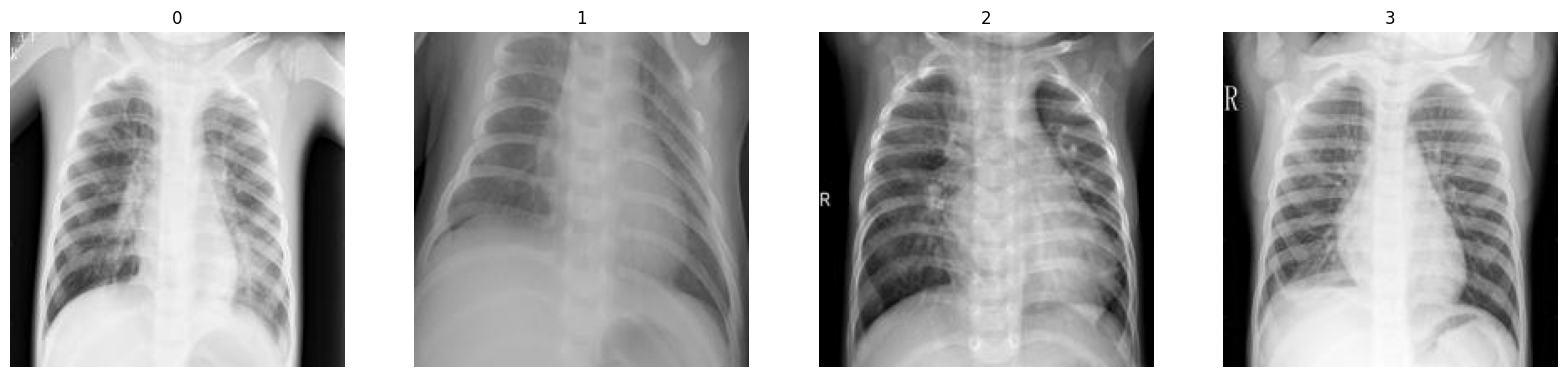

In [15]:
plot_images(train_dir_pneumonia)

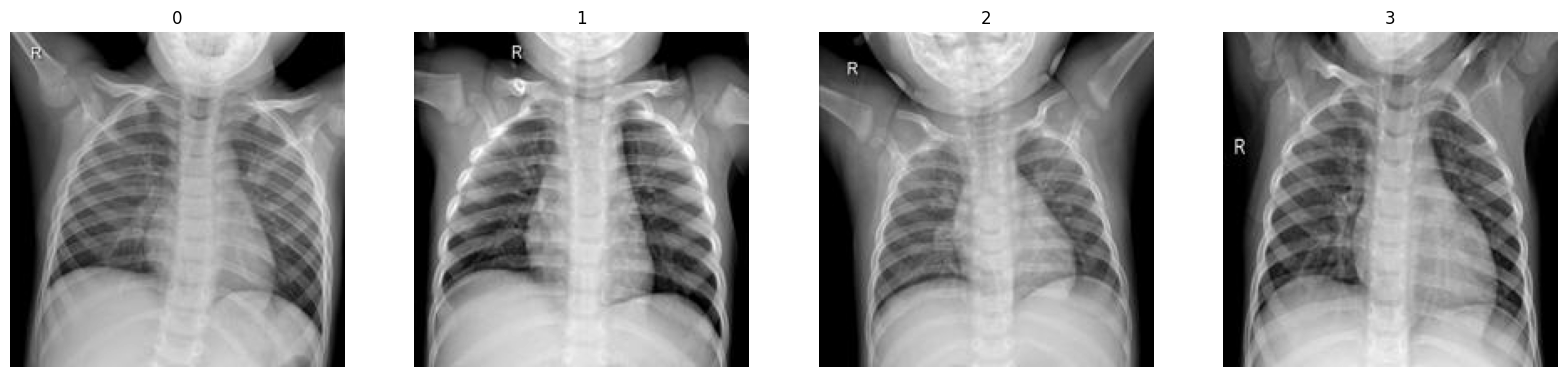

In [16]:
plot_images(train_dir_normal)

Pneumonia will be class 1 and Normal will be class 0.

In [17]:
def define_x_y(dir):
    x = []
    y = []
    for cl in os.listdir(dir):
        for img in get_paths(dir, cl):
            x.append(cv2.imread(img, cv2.IMREAD_GRAYSCALE))
            if cl == 'PNEUMONIA':
                y.append(1)
            else:
                y.append(0)
    x=np.array(x)
    y = np.array(y)
    return x, y

In [18]:
x_train,y_train=define_x_y(train_dir)

In [19]:
x_val,y_val=define_x_y(val_dir)
x_test,y_test=define_x_y(test_dir)

In [20]:
x_train.shape

(5216, 200, 200)

In [21]:
img_size=200
x_train = x_train.reshape(-1,img_size,img_size,1)
x_val = x_val.reshape(-1,img_size,img_size,1)
x_test = x_test.reshape(-1,img_size,img_size,1)

In [22]:
x_train= tf.cast(x_train, tf.float32)
x_val=tf.cast(x_val, tf.float32)
x_test=tf.cast(x_test, tf.float32)

x_train = tf.image.resize(x_train[:], (10,10)).numpy()
x_val = tf.image.resize(x_val[:], (10,10)).numpy()
x_test = tf.image.resize(x_test[:], (10,10)).numpy()

# 2. CNN

In [23]:
cnn_model = Sequential()

cnn_model.add(Conv2D(8, (2, 2), activation='relu', input_shape=(10, 10, 1)))


cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

In [24]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 8)           40        
                                                                 
 flatten (Flatten)           (None, 648)               0         
                                                                 
 dense (Dense)               (None, 32)                20768     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20841 (81.41 KB)
Trainable params: 20841 (81.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
cnn_model.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy',metrics=['accuracy'])
cnn_history = cnn_model.fit(x_train, y_train, steps_per_epoch=100,
                        validation_data=(x_test, y_test),
                        epochs=10, batch_size=5)

Epoch 1/10
100/100 [==============================] - 6s 9ms/step - loss: 9.3117 - accuracy: 0.7540 - val_loss: 3.4493 - val_accuracy: 0.7484
Epoch 2/10
100/100 [==============================] - 1s 6ms/step - loss: 2.1512 - accuracy: 0.8360 - val_loss: 5.3030 - val_accuracy: 0.7260
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 1.6472 - accuracy: 0.8820 - val_loss: 4.8713 - val_accuracy: 0.7372
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 2.2000 - accuracy: 0.8580 - val_loss: 14.2687 - val_accuracy: 0.6314
Epoch 5/10
100/100 [==============================] - 1s 6ms/step - loss: 1.5918 - accuracy: 0.8740 - val_loss: 5.1096 - val_accuracy: 0.7212
Epoch 6/10
100/100 [==============================] - 1s 6ms/step - loss: 1.6008 - accuracy: 0.9000 - val_loss: 11.7169 - val_accuracy: 0.6603
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 1.5285 - accuracy: 0.8780 - val_loss: 6.3048 - val_accuracy: 0.7324
Epoc

In [26]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 4ms/step - loss: 2.9761 - accuracy: 0.7885


# 3. QCNN

In [27]:
class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = filter_size
        self.depth = depth
        self.learning_params = []
        self.QCNN_layer_gen()
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param

    def _QConv(self, step, target, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])

    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        pixels = self.filter_size**2
        if np.log2(pixels) % 1 != 0:
            raise NotImplementedError("filter size: 2^n only available")
        cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))

        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(pixels).astype(np.int32))]
        for step in step_size:
            for target in range(0, pixels, 2*step):
                QCNN_circuit.append(self._QConv(step, target, cirq_qubits))

        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit
        self.params = input_params + self.learning_params
        self.op = cirq.Z(cirq_qubits[0])

    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1

        self.kernel = self.add_weight(name="kenel",
                                      shape=[self.depth,
                                             self.channel,
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)

    def call(self, inputs):
        stack_set = None
        for i in range(self.num_x):
            for j in range(self.num_y):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1)
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])

        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        outputs = []
        for i in range(self.depth):
            controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
            outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))


        output_tensor = tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        return self.activation(output_tensor)

    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        input_data = tf.concat([input_data, controller], 1)
        QCNN_output = tfq.layers.Expectation()(circuit_inputs,
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
        return tf.math.reduce_sum(QCNN_output, 3)

In [28]:
qcnn_model = Sequential()


qcnn_model.add(QConv(filter_size=2, depth=8, activation='relu',name='qconv1', input_shape=(10, 10, 1)))

qcnn_model.add(Flatten())
qcnn_model.add(Dense(32, activation='relu'))
qcnn_model.add(Dense(1, activation='sigmoid'))

In [29]:
qcnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qconv1 (QConv)              (None, 9, 9, 8)           48        
                                                                 
 flatten_1 (Flatten)         (None, 648)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                20768     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20849 (81.44 KB)
Trainable params: 20849 (81.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


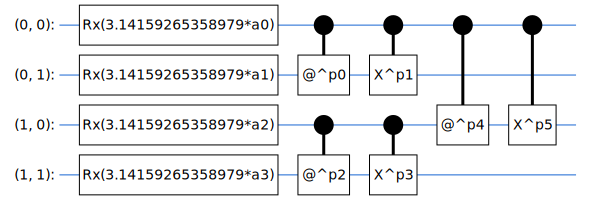

In [30]:
SVGCircuit(QConv(filter_size=2, depth=0, activation='relu').circuit)

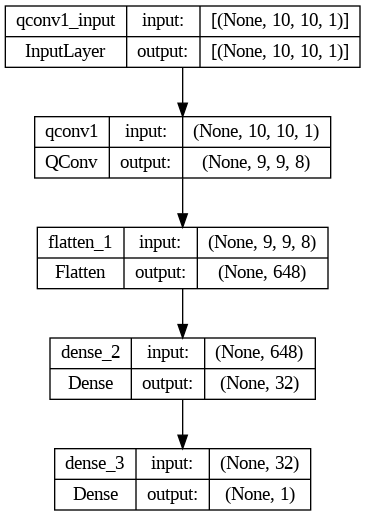

In [31]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(qcnn_model, to_file='model_shapes.png', show_shapes=True)

In [32]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['accuracy'])

qcnn_history = qcnn_model.fit(x_train, y_train,steps_per_epoch=100,
                        validation_data=(x_test, y_test),
                        epochs=10, batch_size=5)

Epoch 1/10
100/100 [==============================] - 86s 774ms/step - loss: 0.6037 - accuracy: 0.7320 - val_loss: 0.7978 - val_accuracy: 0.6250
Epoch 2/10
100/100 [==============================] - 90s 908ms/step - loss: 0.5951 - accuracy: 0.7280 - val_loss: 0.6637 - val_accuracy: 0.6234
Epoch 3/10
100/100 [==============================] - 74s 743ms/step - loss: 0.5875 - accuracy: 0.7360 - val_loss: 0.7575 - val_accuracy: 0.6250
Epoch 4/10
100/100 [==============================] - 91s 911ms/step - loss: 0.6027 - accuracy: 0.7020 - val_loss: 0.6659 - val_accuracy: 0.6122
Epoch 5/10
100/100 [==============================] - 88s 889ms/step - loss: 0.5235 - accuracy: 0.7720 - val_loss: 0.7536 - val_accuracy: 0.6250
Epoch 6/10
100/100 [==============================] - 88s 888ms/step - loss: 0.5531 - accuracy: 0.7460 - val_loss: 0.7071 - val_accuracy: 0.6250
Epoch 7/10
100/100 [==============================] - 88s 881ms/step - loss: 0.5550 - accuracy: 0.7640 - val_loss: 0.7155 - val_ac

In [33]:
test_loss, test_acc = qcnn_model.evaluate(x_test, y_test)

20/20 [==============================] - 27s 1s/step - loss: 0.8107 - accuracy: 0.6250


# 4. Comparison

In [48]:
import matplotlib as mpl
def plot_loss_curves(cnn_loss, qcnn_loss):
    fig = plt.figure()
    plt.plot(np.arange(len(cnn_loss)) + 1, cnn_loss, "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_loss)) + 1, qcnn_loss, "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, 0, 16])
    plt.legend(fontsize=12)
    plt.xlabel("Epochs")
    plt.ylabel("Test set loss")
    plt.grid(True)
    fig.savefig('loss.png',)

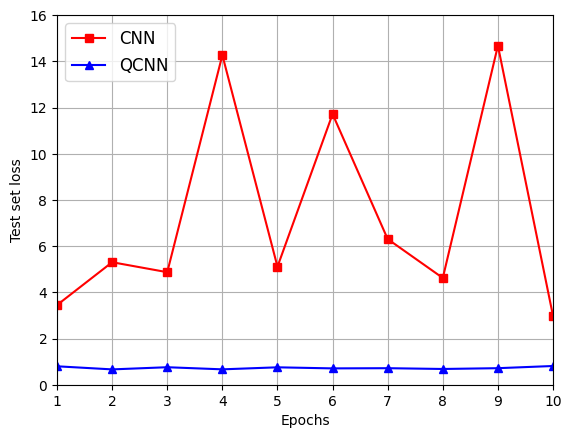

In [49]:
plot_loss_curves(cnn_history.history['val_loss'], qcnn_history.history['val_loss'])

In [40]:
def plot_acc_curves(cnn_acc, qcnn_acc):
    fig = plt.figure()
    plt.plot(np.arange(len(cnn_acc)) + 1, cnn_acc, "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_acc)) + 1, qcnn_acc, "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 10, 0.6, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set accuracy")
    fig.savefig('accuracy.png')

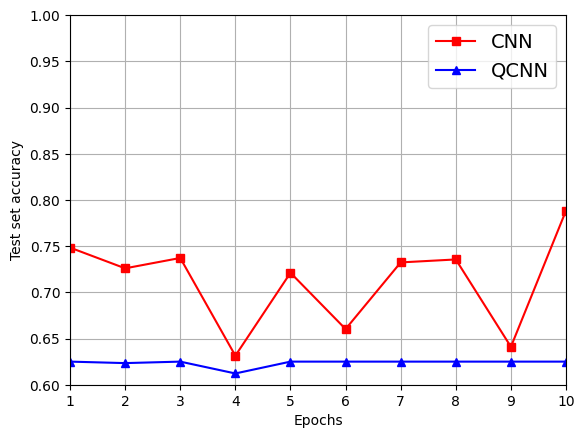

In [41]:
plot_acc_curves(cnn_history.history['val_accuracy'], qcnn_history.history['val_accuracy'])